In [1]:
import pickle
from pathlib import Path
from matplotlib import cm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import ttest_1samp

In [3]:
import seaborn as sns
import numpy as np

In [4]:
bcounts = []
for i in [1,2,3]:
    files_path = Path("data/bcounts/underlying_"+str(i))
    for element in files_path.glob("*/bcounts.pkl"):
        bcounts.append(pickle.load(open(element, 'rb')))

In [5]:
column_bcounts = pickle.load(open(Path("data/bcounts/column").glob("**/bcounts.pkl").__next__(),'rb'))

In [6]:
def compute_ostt(bcounts, colum_bcounts, max_dim = 10):
    statistic_matrices = []
    pvalue_matrices = []
    diff_matrices = []
    for dimension in range(1,max_dim+1):
        statistic = np.zeros((dimension+1, dimension+1))
        pvalues = np.zeros((dimension+1, dimension+1))
        diff = np.zeros((dimension+1, dimension+1))
        for i in range(dimension):
            for j in range(i+1):
                hyp = column_bcounts[dimension][i+1][j]
                samples = [elem[dimension][i+1][j] for elem in bcounts]
                result = ttest_1samp(samples, hyp)
                statistic[i+1][j] = result[0]
                pvalues[i+1][j] = result[1]/2
                diff[i+1][j] = np.average(samples) - hyp
        statistic[statistic == 0] = np.nan
        pvalues[pvalues == 0] = np.nan
        diff[diff == 0] = np.nan
        statistic_matrices.append(statistic)
        pvalue_matrices.append(pvalues)
        diff_matrices.append(diff)
    return statistic_matrices, pvalue_matrices, diff_matrices

In [7]:
def plot_ostt(statistic_matrices, pvalue_matrices, diff_matrices, max_dim = 6, name = "ostt"):
    for dimension in range(1,max_dim+1):

        dvalue = np.nanmax(np.absolute(diff_matrices[dimension]))
        svalue = np.nanmax(np.absolute(statistic_matrices[dimension]))
        fig, axes = plt.subplots(1,3, figsize = (15,6))
        sns.heatmap(diff_matrices[dimension], cmap = cm.get_cmap('bwr'), ax = axes[0], annot = True,
                   vmin = -dvalue, vmax = dvalue)
        sns.heatmap(statistic_matrices[dimension], cmap = cm.get_cmap('bwr'), ax = axes[1], annot = True,
                   vmin = -svalue, vmax = svalue)
        sns.heatmap(np.log(pvalue_matrices[dimension]), cmap = cm.get_cmap('viridis'), ax = axes[2], annot = True)
        axes[0].set_title('Difference in count')
        axes[1].set_title('Difference in statistic')
        axes[2].set_title('Log10 of pvalue')
        fig.suptitle(f"Summary of t-tests in dim {dimension+1}")
        fig.savefig(name+str(dimension), facecolor = 'white')

In [8]:
def plot_significance_groups(statistic_matrices, pvalue_matrices, diff_matrices, max_dim = 6, name = "sgroups"):
    for dimension in range(1, max_dim+1):
        pvalue_matrix = pvalue_matrices[dimension]
        one_star = pvalue_matrix < 0.05
        two_star = pvalue_matrix < 0.01
        three_star = pvalue_matrix < 0.001
        significance_matrix = np.ones(pvalue_matrix.shape)
        significance_matrix += one_star
        significance_matrix += two_star
        significance_matrix += three_star
        significance_matrix = np.multiply(significance_matrix, np.sign(statistic_matrices[dimension]))
        
        fig, ax = plt.subplots(1,1, figsize = (8,8))
        sns.heatmap(significance_matrix, cmap = cm.get_cmap('bwr'), ax = ax, annot = False,
                   vmin = -4, vmax = 4)
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks(np.linspace(-4,4,9))
        colorbar.set_ticklabels([
        "***, fewer counts",
        "**, fewer counts",
        "*, fewer counts",
        "ns, fewer counts",
        "equal counts",
        "ns, more counts",
        "*, more counts",
        "**, more counts",
        "***, more counts"
        ])
        ax.set_title(f"Significance of one-sided, one sample t-test of underlying vs column, dim {dimension+1}")
        fig.savefig(name+str(dimension), facecolor = 'white')
        

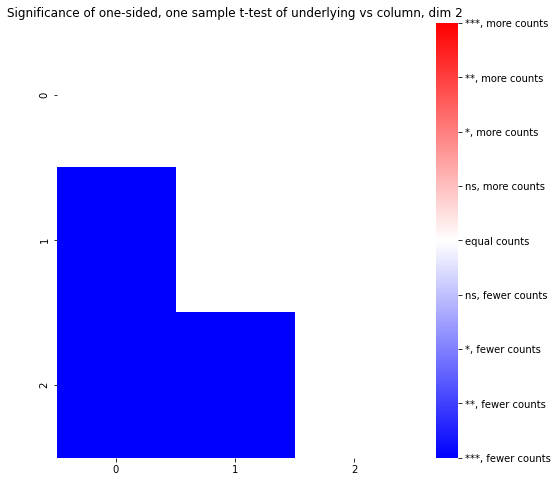

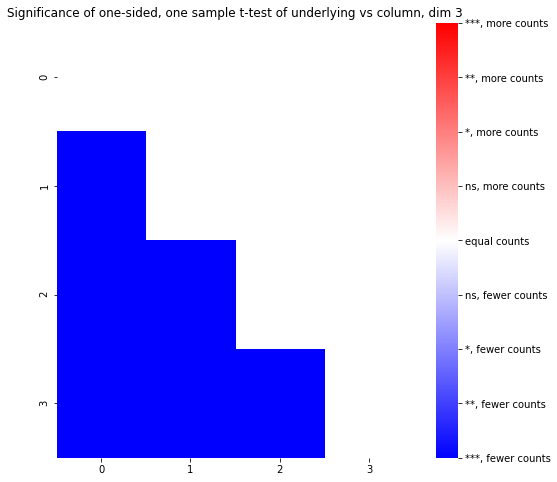

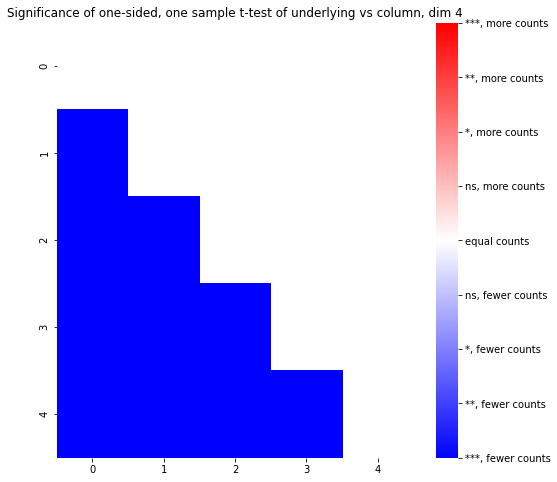

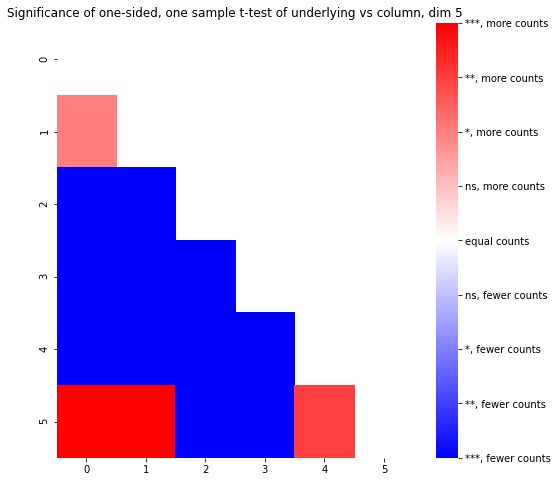

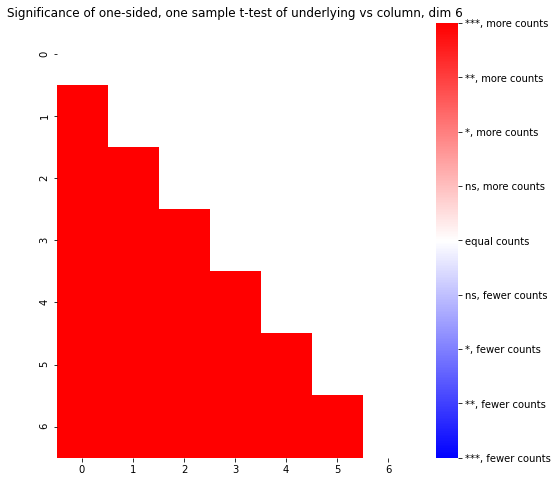

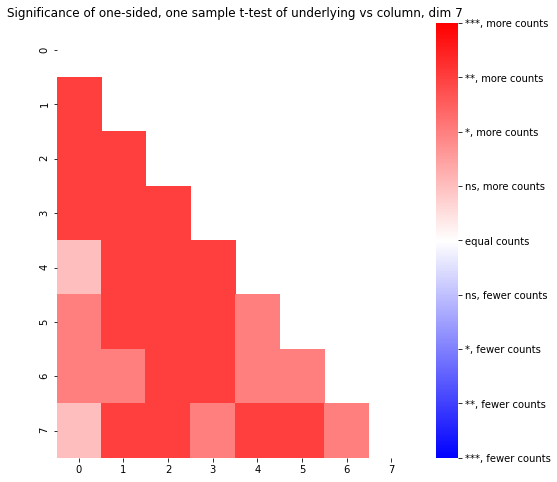

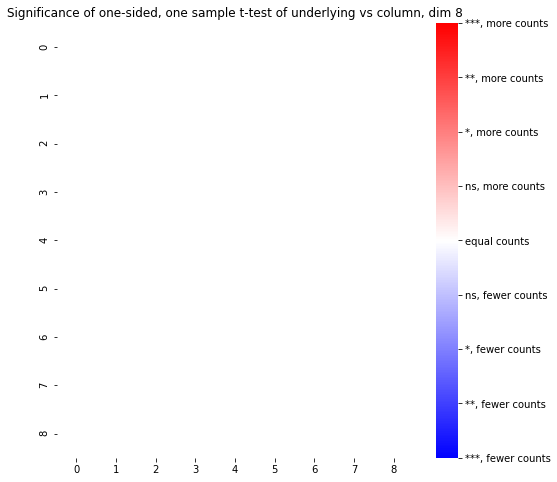

In [9]:
s, p, d = compute_ostt(bcounts, column_bcounts)
plot_significance_groups(s, p, d, 7, "significance_absolute")

<ipython-input-7-c585baedaf71>:4: RuntimeWarning: All-NaN slice encountered
  dvalue = np.nanmax(np.absolute(diff_matrices[dimension]))
<ipython-input-7-c585baedaf71>:5: RuntimeWarning: All-NaN slice encountered
  svalue = np.nanmax(np.absolute(statistic_matrices[dimension]))
/home/paperspace/miniconda3/envs/thesis38/lib/python3.8/site-packages/seaborn/matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/paperspace/miniconda3/envs/thesis38/lib/python3.8/site-packages/seaborn/matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


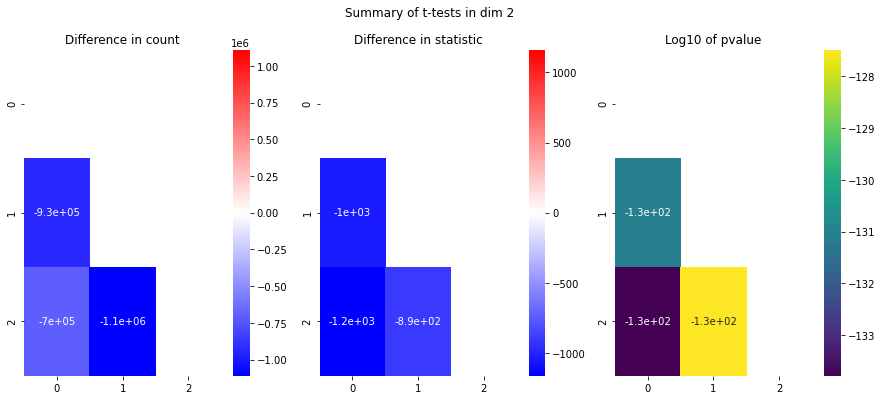

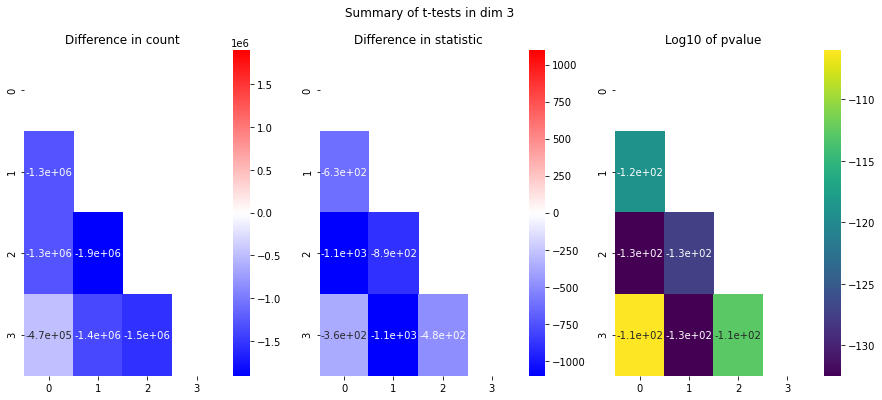

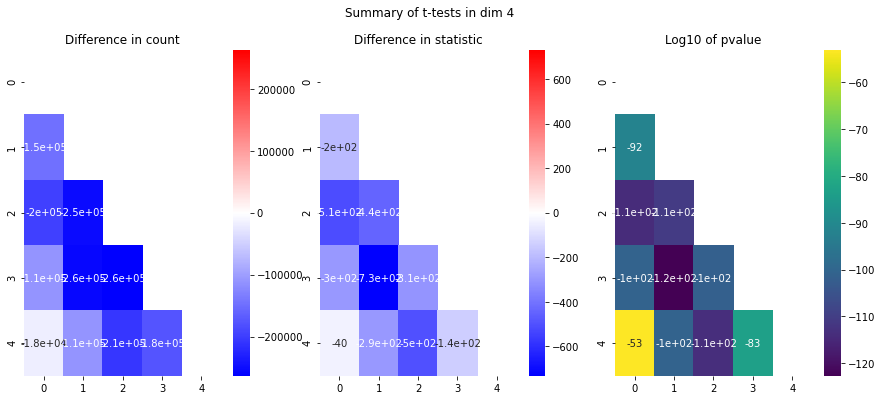

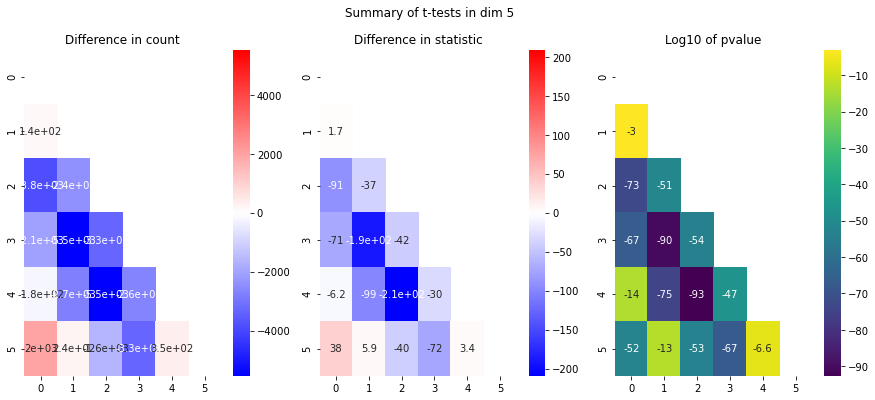

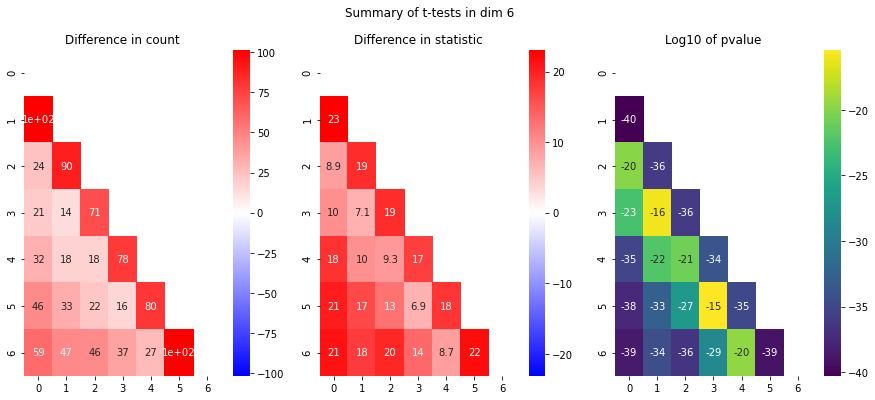

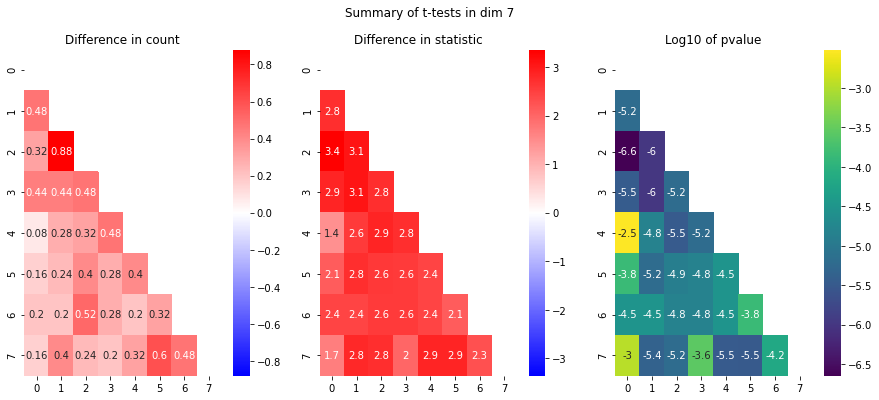

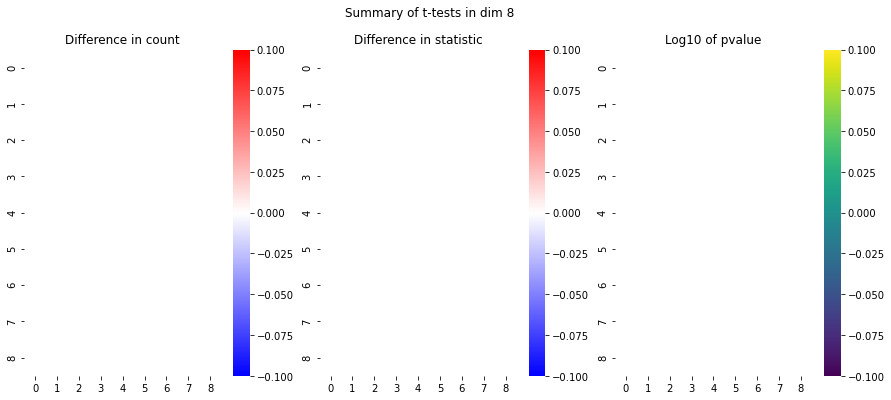

In [10]:
s, p, d = compute_ostt(bcounts, column_bcounts)
plot_ostt(s, p, d, 7, "ttest_absolute")

In [11]:
def normalize_matrix(m):
    return m/m[0][-1]

In [12]:
for count in bcounts:
    for key in count.keys():
        count[key] = normalize_matrix(count[key])

<ipython-input-11-7c2800ae6978>:2: RuntimeWarning: invalid value encountered in true_divide
  return m/m[0][-1]


In [13]:
for key in column_bcounts.keys():
    column_bcounts[key] = normalize_matrix(column_bcounts[key])

<ipython-input-11-7c2800ae6978>:2: RuntimeWarning: invalid value encountered in true_divide
  return m/m[0][-1]


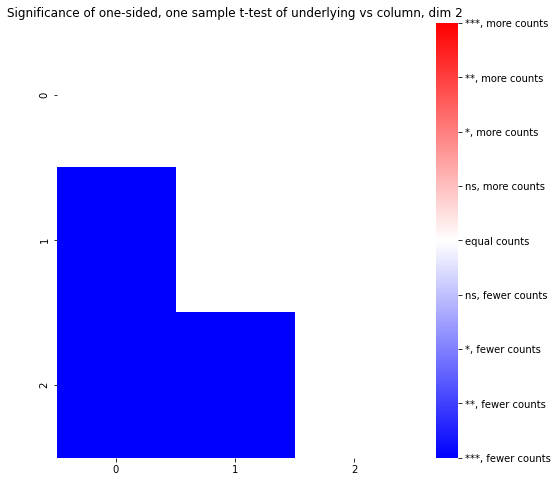

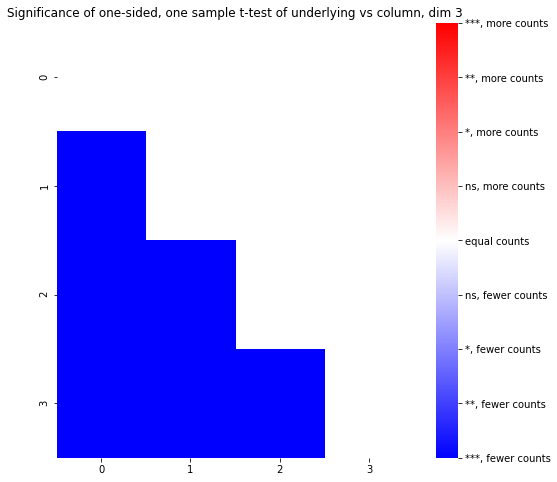

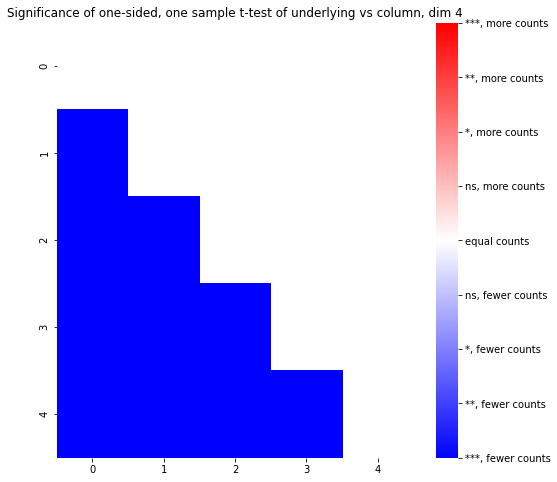

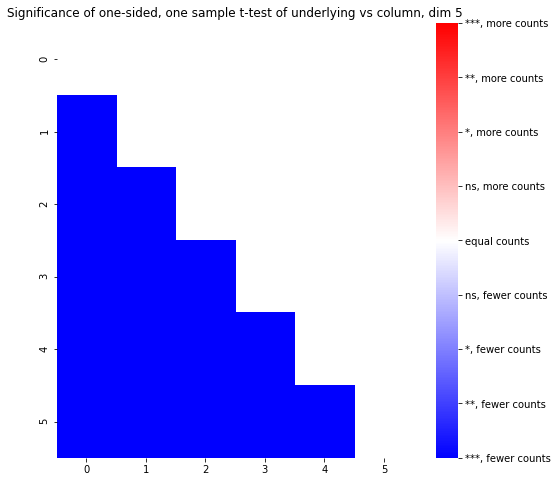

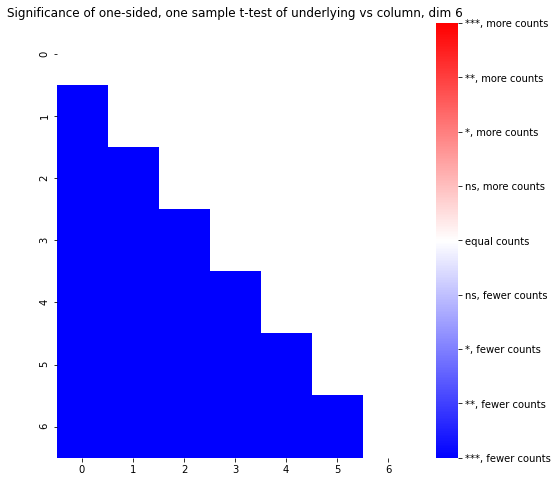

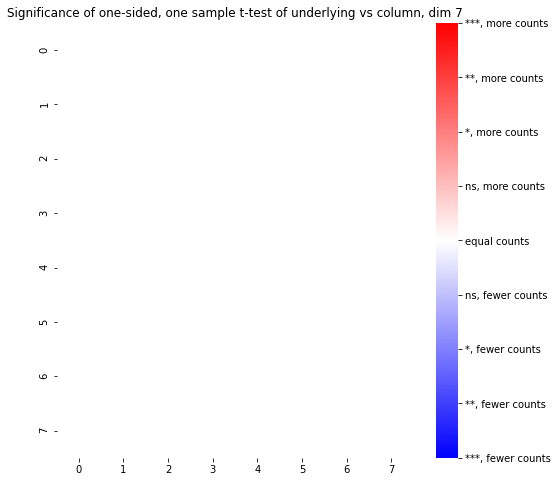

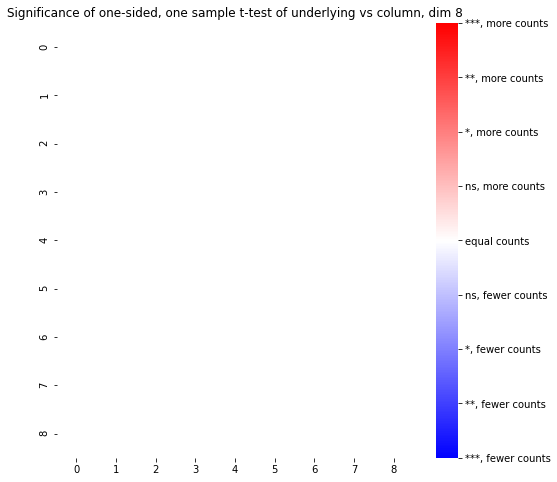

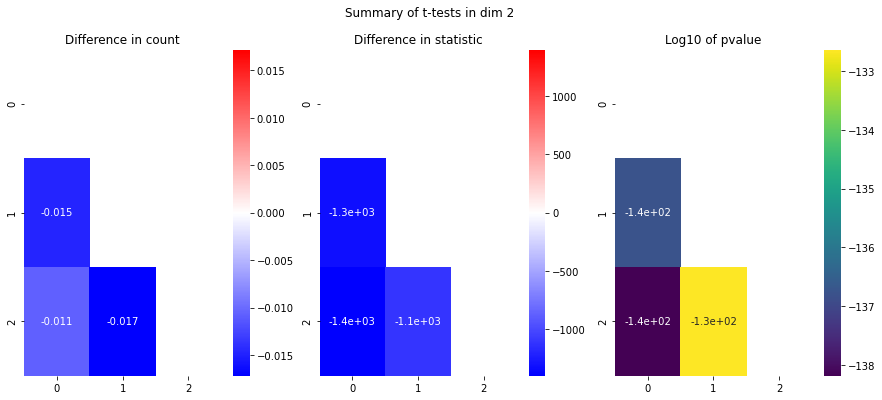

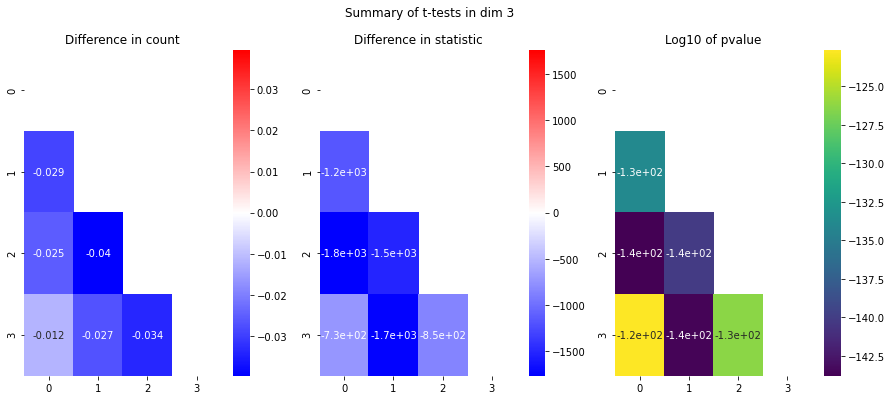

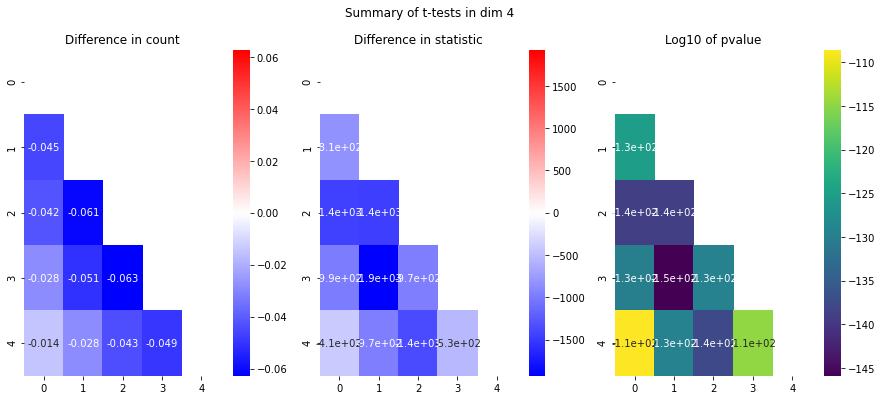

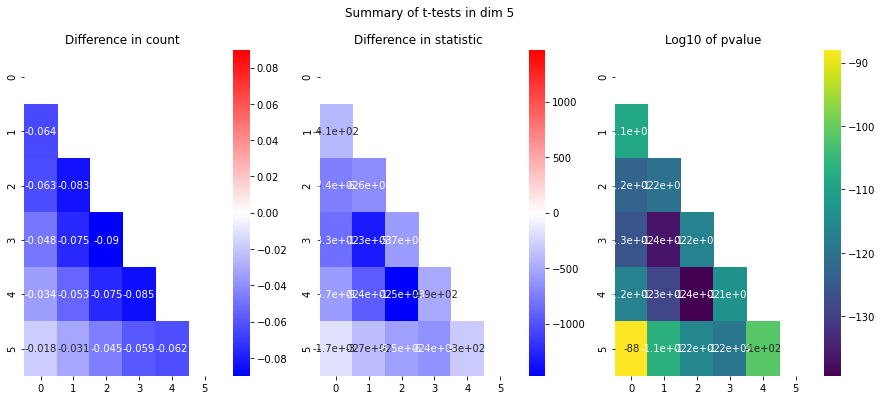

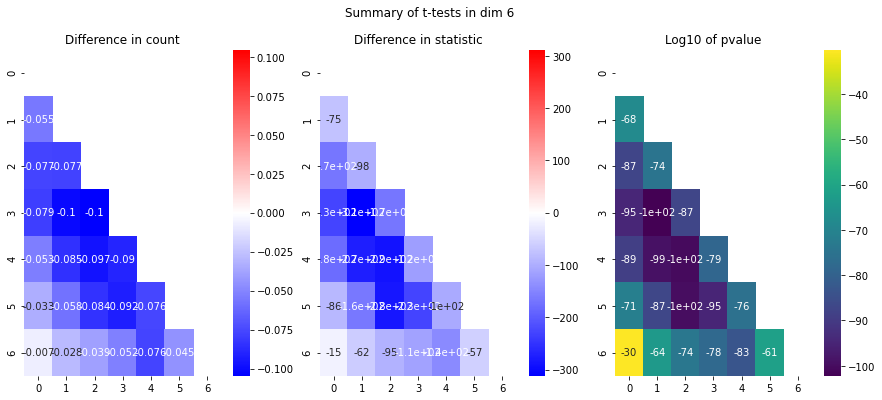

In [14]:
s, p, d = compute_ostt(bcounts, column_bcounts)
plot_significance_groups(s, p, d, 7, "significance_normalized")
plot_ostt(s, p, d, 5, "ttest_normalized")

In [15]:
def percentize_matrix(m):
    return m/np.sum(np.tril(m))

In [16]:
for count in bcounts:
    for key in count.keys():
        count[key] = percentize_matrix(count[key])

In [17]:
for key in column_bcounts.keys():
    column_bcounts[key] = percentize_matrix(column_bcounts[key])

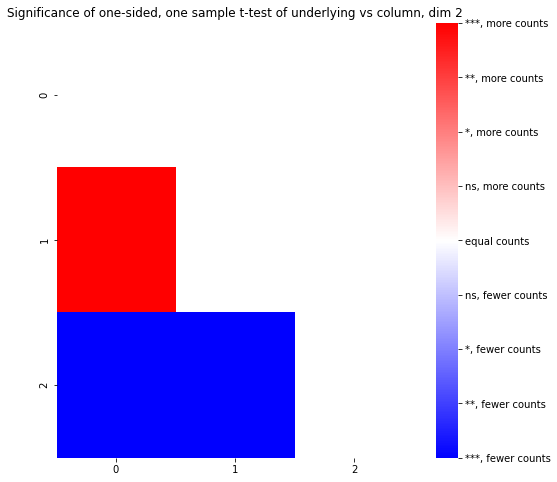

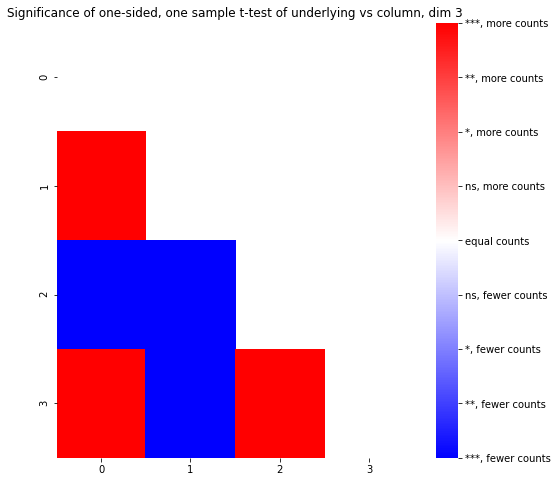

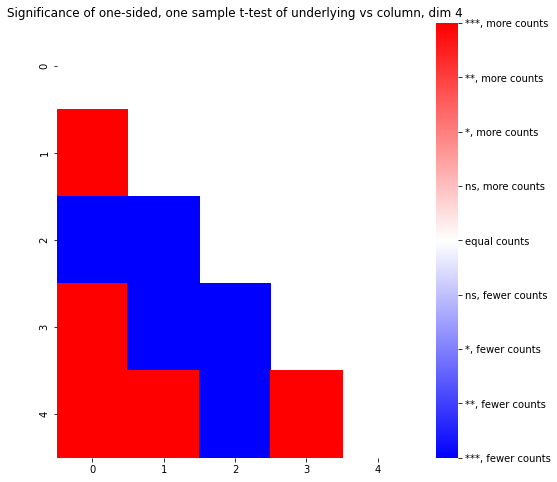

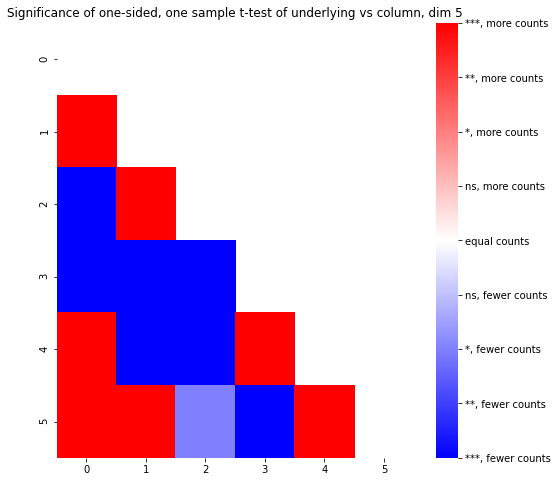

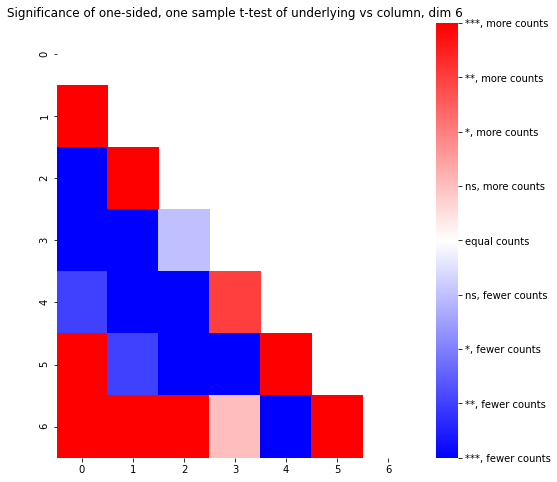

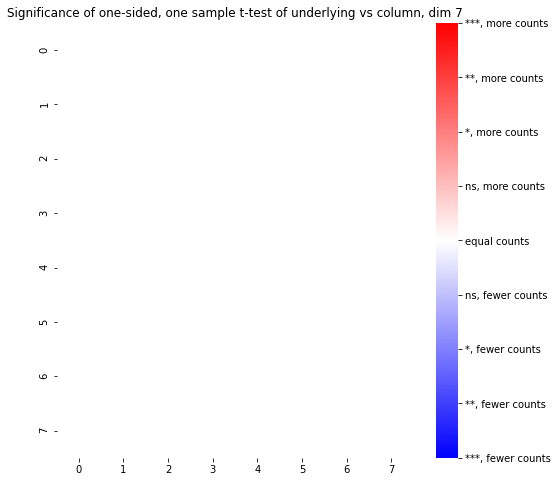

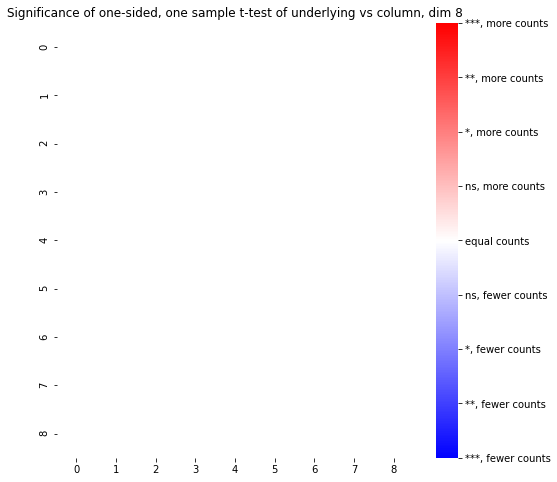

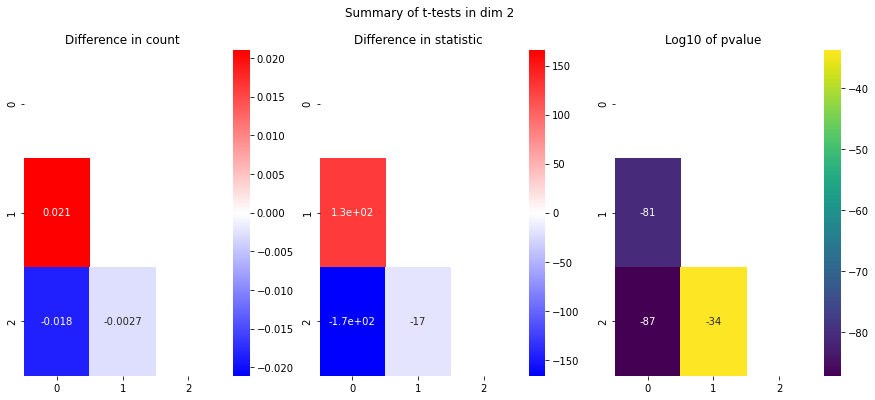

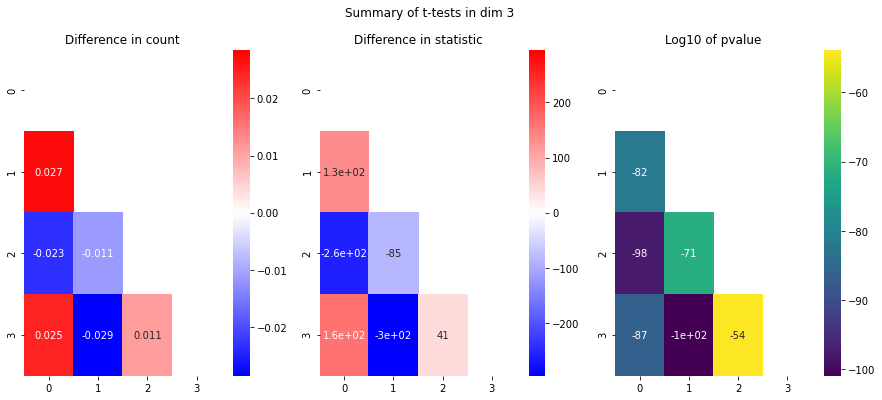

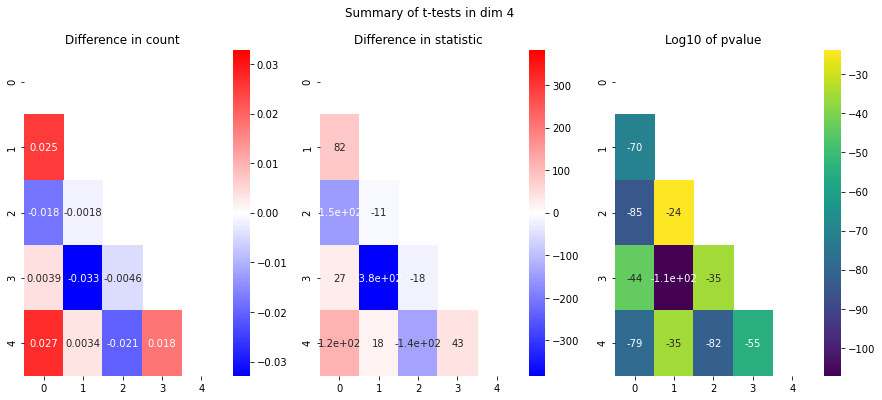

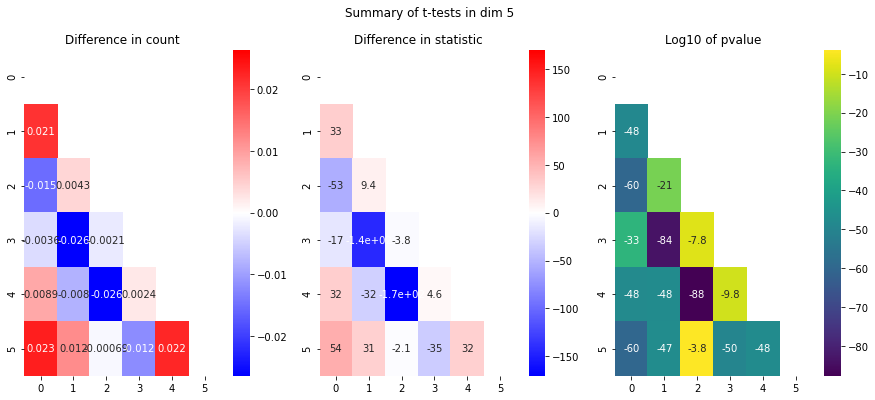

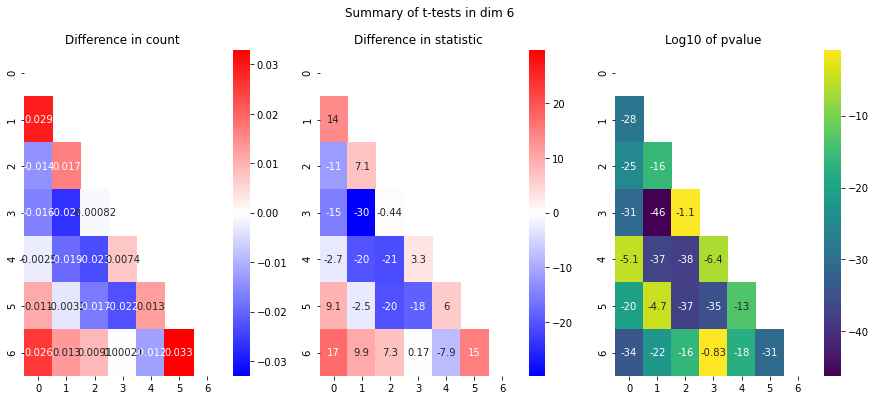

In [18]:
s, p, d = compute_ostt(bcounts, column_bcounts)
plot_significance_groups(s, p, d, 7, "significance_absolute")
plot_ostt(s, p, d, 5, "ttest_percent")